In [51]:
import pandas as pd
import json
import numpy as np
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from scipy.spatial.distance import mahalanobis
from scipy.signal import find_peaks
from collections import Counter
from sklearn.linear_model import LogisticRegression
import optuna
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import umap
import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Introduction
Top-down proteomics is a mass spectrometry-based approach that involves the analysis of intact proteins rather than their enzymatically digested peptides. It allows for the identification of proteoforms to uncover information about post-translational modifications and complex isoforms. However, the resulting top-down mass spectra face several challenges related to quality control, due to fragmentation complexity, spectral noise and interference, and technical variability. To this end, unbiased quality control methods are important to automate filtering out of the low-quality scans when features or criteria are not known a priori.

## Data
The data used is a single biological and technical replicate of multiple liver cirrhosis tissue samples taken on March 22nd, 2023 from the Kelleher Research Group (20221103_chm134_Cirrhosis_FlowChip15_AA15004EM1_TreatmentA_biorep04_techrep01.raw). 

The dataset consists of 12,305 scans with a 70/10/20 train-validation-test split. It has original features from the raw dataset that include: 

1. First Mz

2. Last Mz

3. Length

4. Intensity (a list of intensity values)

5. Mz (a list of Mz values)

6. Value (a Boolean variable whether a proteoform was identified)


The binary response variable, Value, is True for high-quality spectra and False for poor-quality spectra. Approximately 49% of observations had Value = True, while 51% had Value = False.

There were 5 new created features from the original features in the raw dataset: 

1. Kurtosis (kurtosis of intensity values)

2. Skew (skew of intensity values)

3. RMS (root mean squared of intensity values)

4. NumberLargePeaks (number of peaks with intensity > 0.2 x max(intensity) that are 2 Mz apart from another peak)

5. LogRatioVectors (log ratio of binned sum of intensities - from Mz range of 500-1500 with bin size = 25). 


The below code created these new features and organized them into a new dataset, which was then split into train, validation, and test sets for future use.

In [3]:
data = pd.read_csv('original_data.csv')

In [4]:
# convert from strings to list of floats
data['Intensity'] = data['Intensity'].apply(json.loads)
data['Mz'] = data['Mz'].apply(json.loads)
data['Sum'] = data['Sum'].apply(json.loads)

In [5]:
def calculate_log_ratios(sum_vector, epsilon=1e-10):
    # calculate log-ratios for consecutive bins
    log_ratios = [np.log((sum_vector[i+1] + epsilon) / (sum_vector[i] + epsilon)) for i in range(len(sum_vector)-1)]
    
    # sort log-ratios in nonincreasing order
    sorted_log_ratios = sorted(log_ratios, reverse=True)
    
    return sorted_log_ratios

In [6]:
# creating new variables
data['LogRatioVectors'] = data['Sum'].apply(calculate_log_ratios)
data['Kurtosis'] = data['Intensity'].apply(kurtosis)
data['Skew'] = data['Intensity'].apply(skew)
data['RMS'] = data['Intensity'].apply(lambda x: np.sqrt(np.mean(np.square(x))))

In [7]:
# fix logratiovectors to all be 39 length and sorted
data['LogRatioVectors'] = data['LogRatioVectors'].apply(lambda x: x + [np.nan] * (39 - len(x)) if len(x) < 39 else x)
data['LogRatioVectors'] = data['LogRatioVectors'].apply(lambda x: sorted([0 if pd.isna(value) else value for value in x], reverse=True))

In [8]:
# create new dataframe
df_list_column = pd.DataFrame(data['LogRatioVectors'].tolist())

# rename the columns
df_list_column.columns = ['ratio_{}'.format(i) for i in range(39)]

# add more variables
df_list_column['Kurtosis'] = data['Kurtosis']
df_list_column['Skew'] = data['Skew']
df_list_column['RMS'] = data['RMS']

# make response variable binary
data['Boolean'] = data['Value'].notna()
df_list_column['Value'] = data['Boolean']

In [9]:
# knn.csv is the result of previous steps in data
df_list_column = pd.read_csv('new_data.csv')

In [10]:
number_peaks = []
for i in range(0, 12305):
    if (len(data['Intensity'][i]) != data['Length'][i]):
        data['Intensity'][i].insert(0, 0)
    mask = (np.array(data['Mz'][i]) >= 500) & (np.array(data['Mz'][i]) <= 1500)
    new_intensity = np.array(data['Intensity'][i])[mask]
    new_mz = np.array(data['Mz'][i])[mask]
    
    threshold = 0.2 * max(new_intensity)
    selected_values = [value for value in new_intensity if value > threshold]
    
    filtered_values = 0
    
    for value in selected_values:
        index = np.argmax(new_intensity == value)
        mz_at_index = new_mz[index]
        nearby_values = new_intensity[(np.abs(new_mz - mz_at_index) < 2) & (new_intensity > threshold)]

        # If there are no nearby values, add to filtered_values
        if len(nearby_values) and np.argmax(new_intensity == nearby_values[0]) == index:
            filtered_values += 1
    
    number_peaks.append(filtered_values)

In [28]:
data['NumberLargePeaks'] = number_peaks
df_list_column['NumberLargePeaks'] = number_peaks

In [29]:
# train-validation-test stratified split
X = df_list_column.drop(['Value'], axis=1)
y = df_list_column['Value']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)

In [38]:
df_list_column

,ratio_0,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,ratio_7,ratio_8,ratio_9,...,ratio_35,ratio_36,ratio_37,ratio_38,Kurtosis,Skew,RMS,Value,NumberLargerPeaks,NumberLargePeaks
0,35.774883,4.100397,2.081501,2.017439,1.939420,1.548483,1.315670,1.299815,1.148261,1.146022,...,-2.375441,-2.422931,-2.579364,-32.458226,144.211614,10.194003,8063.726691,True,15,15
1,29.931806,2.740178,1.722265,1.285847,1.230793,0.948026,0.605640,0.308273,0.000000,0.000000,...,-1.895062,-2.175713,-30.302133,-32.482910,330.007545,16.512634,4403.697290,True,1,1
2,34.091149,3.656758,3.023492,2.654156,2.429475,2.258178,1.875471,1.743134,1.503170,1.081521,...,-2.808767,-2.889627,-3.414619,-33.543656,247.346601,13.371409,14644.025278,True,9,9
3,31.346985,31.007523,29.840569,1.700875,1.618402,1.571228,1.447945,1.087634,0.446437,0.371296,...,-30.338518,-31.007523,-31.458971,-32.029899,67.969087,6.846932,1782.600655,True,21,21
4,32.697081,3.025047,2.315011,2.165465,1.547576,1.486054,1.145770,0.913988,0.837832,0.567006,...,-2.220192,-2.931464,-3.067065,-31.678746,478.756276,20.088546,6461.501652,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12300,2.395913,2.059727,1.786414,1.692334,1.640503,1.422393,1.097001,0.955620,0.732763,0.707747,...,-1.529149,-1.695502,-2.754032,-3.271593,314.900027,15.085213,7178.342600,False,5,5
12301,2.860851,2.348609,2.273434,1.944381,1.830096,1.784280,1.734922,1.724729,1.622951,1.447931,...,-1.969925,-2.185687,-2.331679,-3.055558,239.984521,13.092507,10779.685048,False,6,6
12302,2.343820,2.120839,2.063416,2.018738,1.362481,1.261547,1.261533,1.132909,1.083668,0.788315,...,-1.539198,-1.549712,-1.772968,-2.139888,288.826570,14.227396,7343.275110,False,8,8
12303,2.913656,2.782605,2.560679,2.385869,2.239629,1.899675,1.451946,1.308927,0.811109,0.629992,...,-2.028608,-2.184432,-2.246047,-2.256160,267.761537,13.523128,9616.344061,False,4,4


## EDA

Looking at distributions of the variables yields insights into differences between average high quality and low quality scans. RMS appears to vary little between scans of different qualities, and Kurtosis similarly has only slight differences between the aggregated scans of different qualities. Skew and NumberLargePeaks appear to show important differences, with low quality scans having lower frequencies of low Skew values and higher frequencies of low NumberLargePeaks values than high quality scans. The first and last ratios (largest and smallest) appear to be the most important differences between the low and high quality scans based on the graphed average ratios across all scans of the two different qualities.

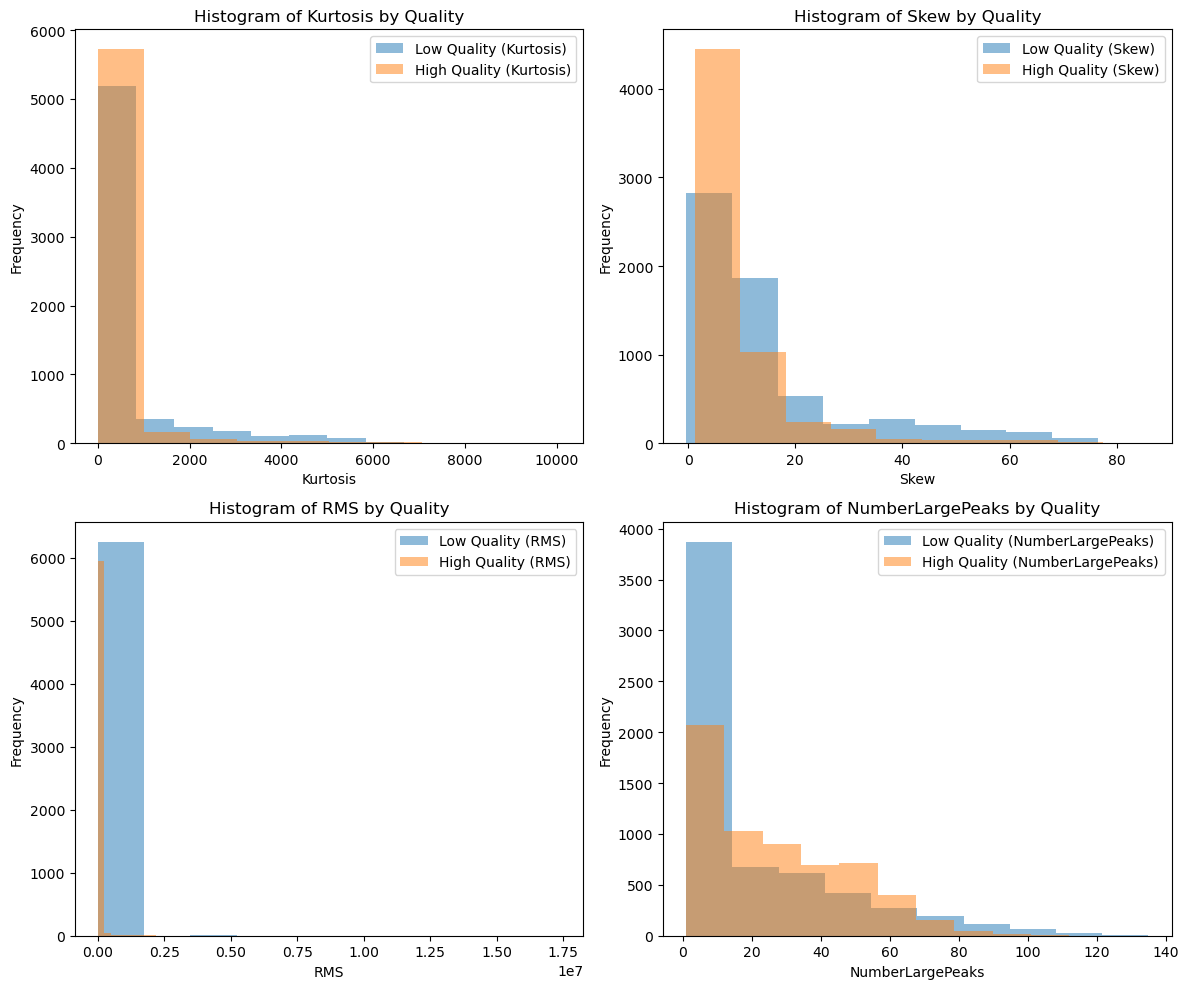

In [32]:
variables_of_interest = ['Kurtosis', 'Skew', 'RMS', 'NumberLargePeaks']
value_labels = {0: 'Low Quality', 1: 'High Quality'}

# plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, variable in enumerate(variables_of_interest):
    row, col = divmod(idx, 2)
    for value in [0, 1]:
        axes[row, col].hist(
            df_list_column.loc[df_list_column['Value'] == value, variable],
            alpha=0.5,
            label=f'{value_labels[value]} ({variable})'
        )

    axes[row, col].set_title(f'Histogram of {variable} by Quality')
    axes[row, col].set_xlabel(variable)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()
    
plt.tight_layout()
plt.show()

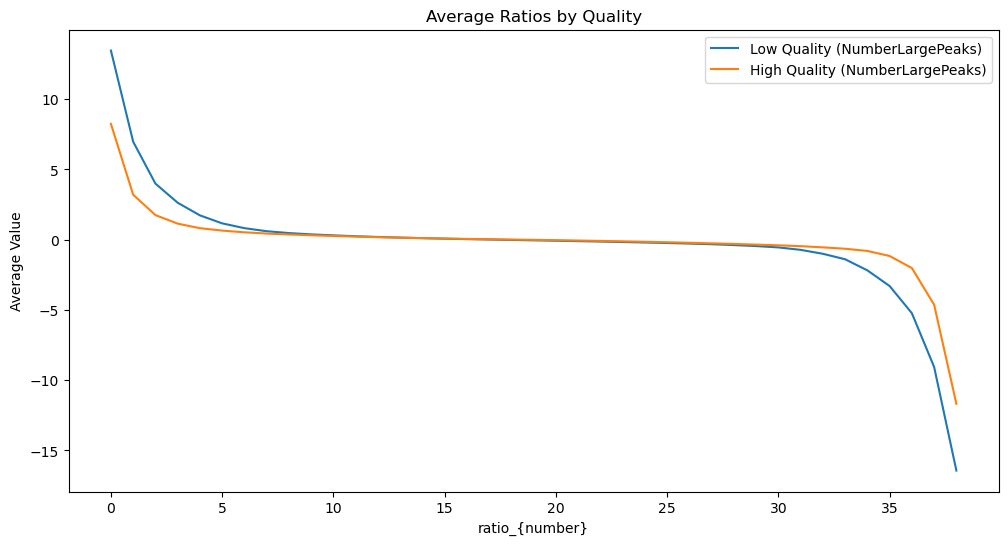

In [35]:
ratio_variables = [f'ratio_{number}' for number in range(39)]

# calculate average ratios for each Value
average_ratios_by_value = {}
for value in [0, 1]:
    average_ratios = [df_list_column.loc[df_list_column['Value'] == value, ratio_var].mean() for ratio_var in ratio_variables]
    average_ratios_by_value[value] = average_ratios

# plot average ratios
plt.figure(figsize=(12, 6))
for value, average_ratios in average_ratios_by_value.items():
    plt.plot(range(39), average_ratios, label=f'{value_labels[value]} ({variable})')

plt.title('Average Ratios by Quality')
plt.xlabel('ratio_{number}')
plt.ylabel('Average Value')
plt.legend()
plt.show()

## Approach
### Scaling and Dimensionality Reduction

The data was first scaled to ensure equal weighing of the features in learning. Because of the appearance of multicollinearity between the many ratio variables, dimensionality reduction was considered to prevent overfitting and for computational efficiency. One method of dimensionality reduction, Principal Component Analysis (PCA), was considered for its performance relative to the original training data (with 95% of variance retained). The performance was measured on the validation dataset for accuracy of logistic regression models with optimized hyperparameters. It appeared that there was little impact made by dimensionality reduction, so the original data was used for its superior performance in later, more complex models.

In [39]:
# scaling and pca
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

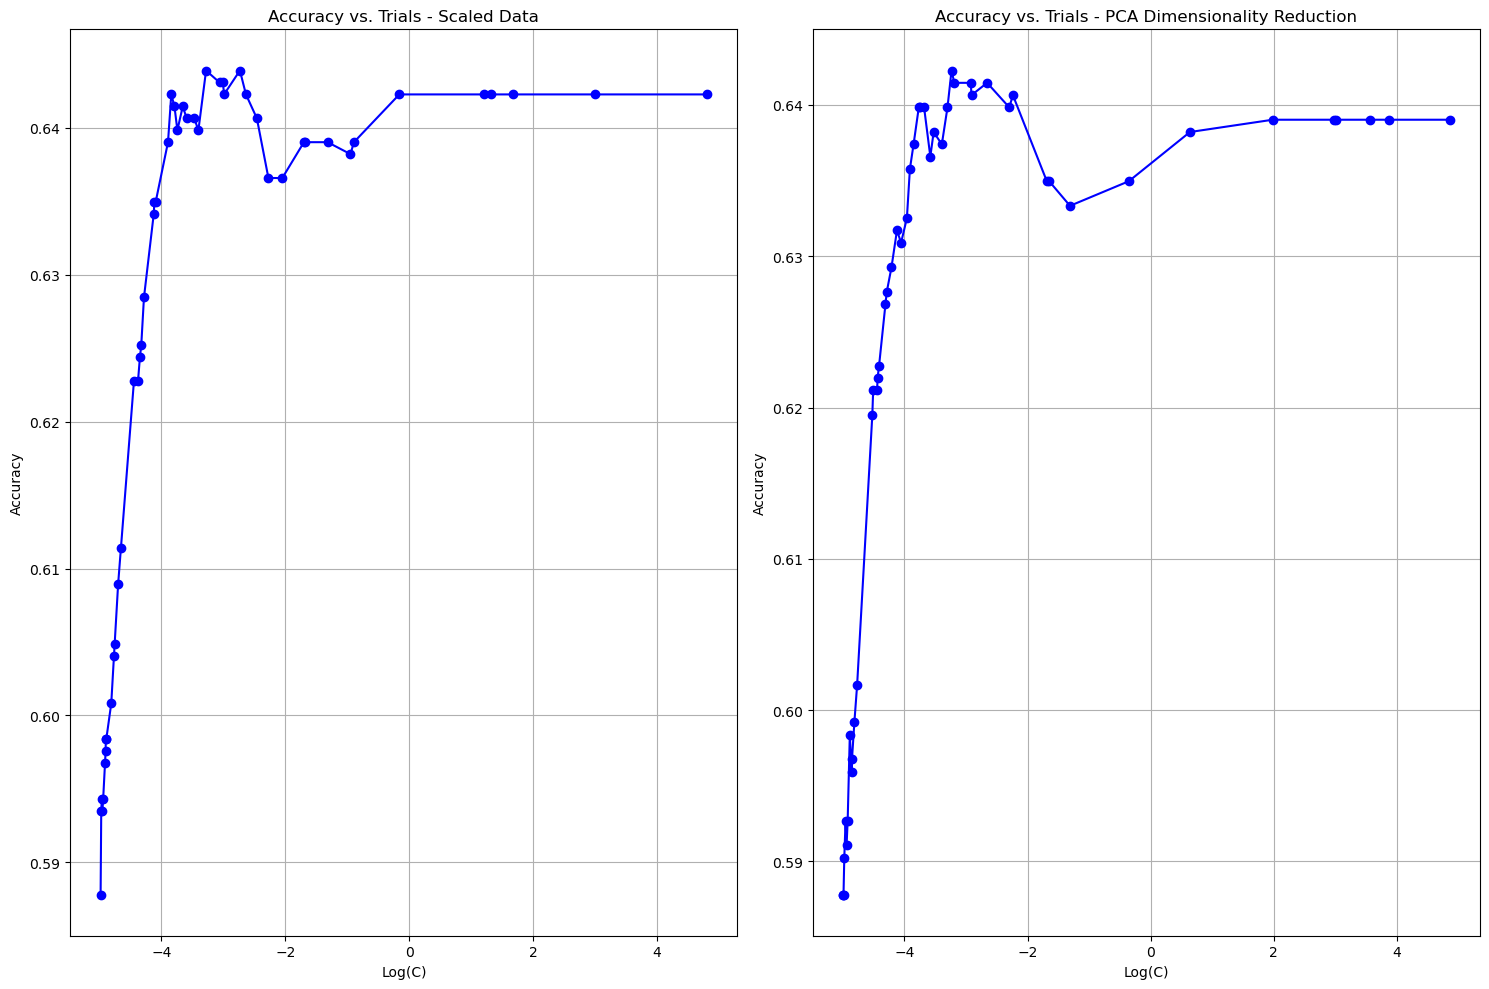

In [41]:
methods = [('PCA', PCA(n_components=0.95))]

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

def plot_scaled_data():
    def objective(trial):
        C = trial.suggest_loguniform('C', 1e-5, 1e5)
        model = LogisticRegression(C=C)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        accuracy = accuracy_score(y_val, y_pred)
        return accuracy

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    trials_sorted = sorted(study.trials, key=lambda trial: trial.params['C'])
    hyperparams = [trial.params['C'] for trial in trials_sorted]
    accuracies = [trial.value for trial in trials_sorted]

    axes[0].plot(np.log10(hyperparams), accuracies, marker='o', linestyle='-', color='b')
    axes[0].set_title('Accuracy vs. Trials - Scaled Data')
    axes[0].set_xlabel('Log(C)')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True)
    
for (method, reducer), ax in zip(methods, axes[1:]):
    X_train_dr = reducer.fit_transform(X_train_scaled)
    X_val_dr = reducer.transform(X_val_scaled)

    def objective(trial):
        C = trial.suggest_loguniform('C', 1e-5, 1e5)
        model = LogisticRegression(C=C)
        model.fit(X_train_dr, y_train)
        y_pred = model.predict(X_val_dr)
        accuracy = accuracy_score(y_val, y_pred)
        return accuracy

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    trials_sorted = sorted(study.trials, key=lambda trial: trial.params['C'])
    hyperparams = [trial.params['C'] for trial in trials_sorted]
    accuracies = [trial.value for trial in trials_sorted]

    ax.plot(np.log10(hyperparams), accuracies, marker='o', linestyle='-', color='b')
    ax.set_title(f'Accuracy vs. Trials - {method} Dimensionality Reduction')
    ax.set_xlabel('Log(C)')
    ax.set_ylabel('Accuracy')
    ax.grid(True)

plot_scaled_data()

plt.tight_layout()
plt.show()

### Logistic Regression
A logistic regression model was first used as a baseline to easily interpret and begin to understand the relationship between attributes and the binary response variable. This served as an initial benchmark to compare future, more complex model performances against. Optuna trials were used to find the optimal value of hyperparameter C, which was tested for its performance on the validation dataset for both accuracy and F1-score. The model accuracy on validation data was approximately 0.64 and F1-score approximately 0.67. The model had double the amount of false positives than false negatives.

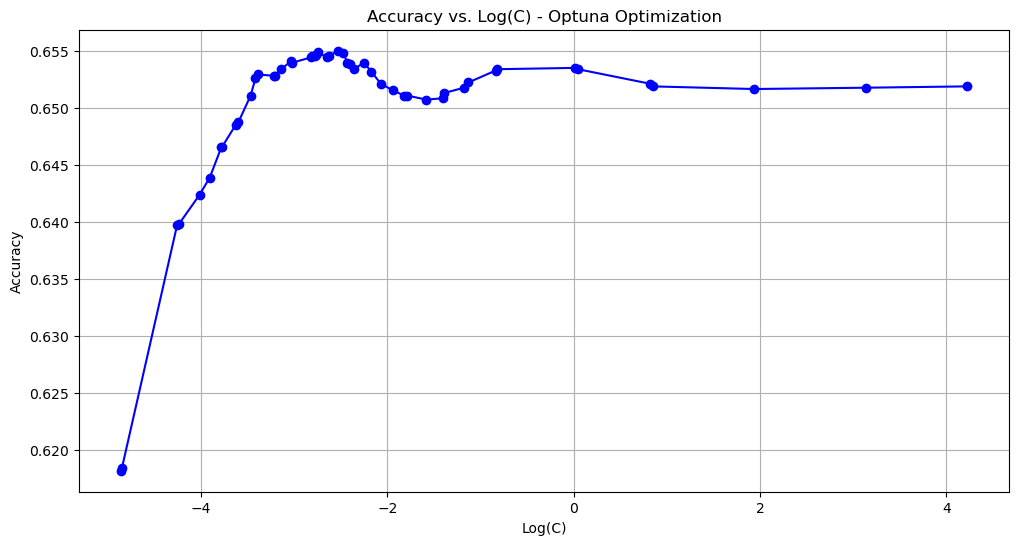

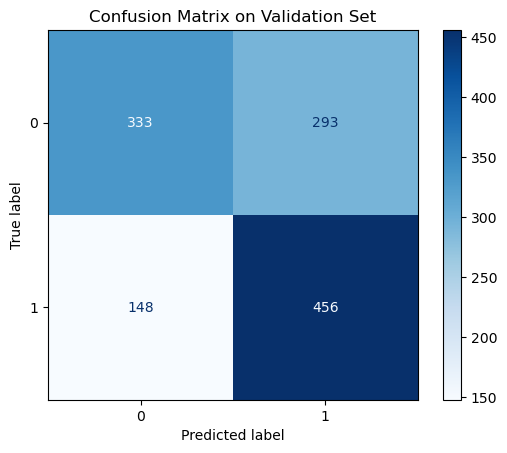

Best Hyperparameters: {'C': 0.002929284981953065}
Best Model Accuracy on Validation Set: 0.6414634146341464
Best Model F1-score on Validation Set: 0.6740576496674057


In [42]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    
    # logistic regression with the suggested C
    logistic_model = LogisticRegression(C=C)
    
    # use cross_val_predict for predictions on the entire training set
    y_pred_cv = cross_val_predict(logistic_model, X_train_scaled, y_train, cv=5)
    
    # calculate accuracy
    accuracy = accuracy_score(y_train, y_pred_cv)
    return accuracy

# optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# extract hyperparameter values and corresponding accuracies
trials_sorted = sorted(study.trials, key=lambda trial: trial.params['C'])
hyperparams = [trial.params['C'] for trial in trials_sorted]
accuracies = [trial.value for trial in trials_sorted]

# plot the results
plt.figure(figsize=(12, 6))
plt.plot(np.log10(hyperparams), accuracies, marker='o', color='b')
plt.title('Accuracy vs. Log(C) - Optuna Optimization')
plt.xlabel('Log(C)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# best hyperparameters
best_params = study.best_params

# train the logistic regression model with the best C on the entire training set
best_logistic_model = LogisticRegression(**best_params)
best_logistic_model.fit(X_train_scaled, y_train)

# results on the validation set
y_pred_val = best_logistic_model.predict(X_val_scaled)
accuracy_test = accuracy_score(y_val, y_pred_val)
f1_test = f1_score(y_val, y_pred_val, average='binary')
conf_matrix_test = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=range(2))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()

print(f"Best Hyperparameters: {best_params}")
print(f"Best Model Accuracy on Validation Set: {accuracy_test}")
print(f"Best Model F1-score on Validation Set: {f1_test}")

### KNN
KNN was tested next using two different distance metrics: euclidean distance and mahalanobis distance. Its non-parametric nature and adaptability to local relationships was thought to lend well to capturing underlying patterns that the logistic regression model was unable to. Different values of neighbors were tested from 3 to 34 (intervals of 5), with Eucliean distance performing better on validation data. The Euclidean distance KNN with n=28 appeared to reach a validation accuracy of approximately >0.755.

In [16]:
def mahalanobis_distance(x, y, inv_cov_matrix):
    diff = x - y
    return np.sqrt(np.dot(np.dot(diff, inv_cov_matrix), diff.T))

# KNN with Euclidean distance
def knn_euclidean(n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

# KNN with Mahalanobis distance
def knn_mahalanobis(n_neighbors):
    # calculate the inverse covariance matrix for Mahalanobis distance
    VI = np.linalg.pinv(np.cov(X_train_scaled, rowvar=False))
    
    # define the Mahalanobis distance metric
    def mahalanobis_metric(x, y):
        return mahalanobis(x, y, VI)
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=mahalanobis_metric)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

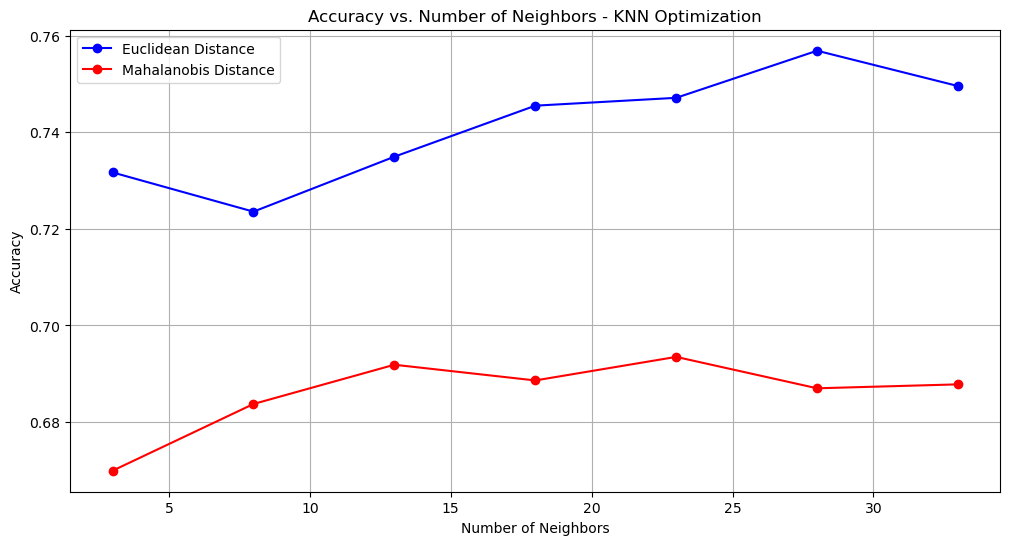

In [17]:
# hyperparameters
neighbors_range = range(3, 34, 5)

# results
accuracies_euclidean = [knn_euclidean(n) for n in neighbors_range]
accuracies_mahalanobis = [knn_mahalanobis(n) for n in neighbors_range]

# plot the results
plt.figure(figsize=(12, 6))
plt.plot(neighbors_range, accuracies_euclidean, label='Euclidean Distance', marker='o', linestyle='-', color='b')
plt.plot(neighbors_range, accuracies_mahalanobis, label='Mahalanobis Distance', marker='o', linestyle='-', color='r')
plt.title('Accuracy vs. Number of Neighbors - KNN Optimization')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Random Forest
A random forest classifier was used to implement a tree-based predictive model to better capture underlying patterns with a different approach. Optuna trials were used to test for optimal hyperparameters across 100 trials, with the best performing model being tested on test data (validation data used during learning). The model accuracy on test data was approximately 0.82 and F1-score approximately 0.82, and the validation accuracy was approximately 0.84 (likely overfitting during learning). The model had equal amounts of false positives and false negatives.

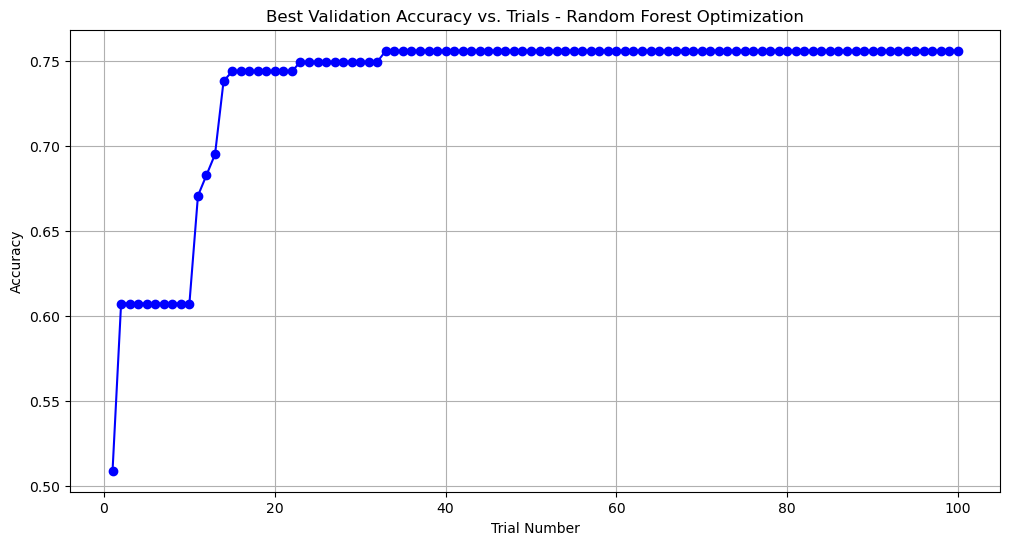

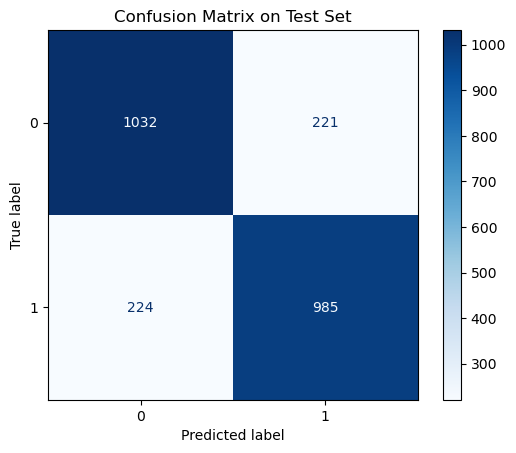

Best Hyperparameters: {'n_estimators': 57, 'max_depth': 29, 'min_samples_split': 0.1952128801070221, 'min_samples_leaf': 0.10027951535280541}
Best Model Accuracy on Test Set: 0.8192526401299757
Best Model F1-score on Test Set: 0.8157349896480331


In [53]:
def objective(trial):
    # define hyperparameters 
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)

    # random forest classifier
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42  
    ).fit(X_train_scaled, y_train)

    y_pred = (rf_model.predict(X_val_scaled) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# create Optuna study 
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
best_accuracy = study.best_value

# track the best accuracy as the trials go on
best_accuracies = []
maximum_accuracy = 0
for trial in study.trials:
    model = RandomForestClassifier(**trial.params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    maximum_accuracy = max(maximum_accuracy, accuracy)
    best_accuracies.append(maximum_accuracy)
    
# plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(study.trials) + 1), best_accuracies, marker='o', linestyle='-', color='b')
plt.title('Best Validation Accuracy vs. Trials - Random Forest Optimization')
plt.xlabel('Trial Number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# train the logistic regression model with the best hyperparameters on the entire training set
best_rf_model = RandomForestClassifier(**best_params)
best_rf_model.fit(X_train_scaled, y_train)

# results on the test set
y_pred_test = best_lgb_model.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test, average='binary')
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=range(2))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

print(f"Best Hyperparameters: {best_params}")
print(f"Best Model Accuracy on Test Set: {accuracy_test}")
print(f"Best Model F1-score on Test Set: {f1_test}")

In [56]:
# results on the train set
y_pred_val = best_lgb_model.predict(X_val_scaled)
accuracy_test_val = accuracy_score(y_val, y_pred_val)
print(f"Best Model Accuracy on Validation Set: {accuracy_test_val}")

Best Model Accuracy on Validation Set: 0.8349593495934959


### LightGBM
A Light Gradient Boosting Machine (LightGBM) model was used to implement ensemble learning through gradient boosting to produce a strong predictive model. Leaf-wise growth ensured faster, efficient convergence of the model. Optuna trials were used to test for optimal hyperparameters across 100 trials, with the best performing model being tested on test data (due to validation data being used in learning). The model accuracy on test data was approximately 0.82 and F1-score approximately 0.82. The model accuracy on validation data was approximately 0.84, indicating that the model is likely overfitting from the learning. The model had equal amounts of false positives and false negatives, and performed similarly to random forest.

In [44]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'verbose': -1,
        'silence': True
    }

    model = lgb.train(params, lgb.Dataset(X_train_scaled, label=y_train), num_boost_round=100)
    y_pred = (model.predict(X_val_scaled) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

In [45]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

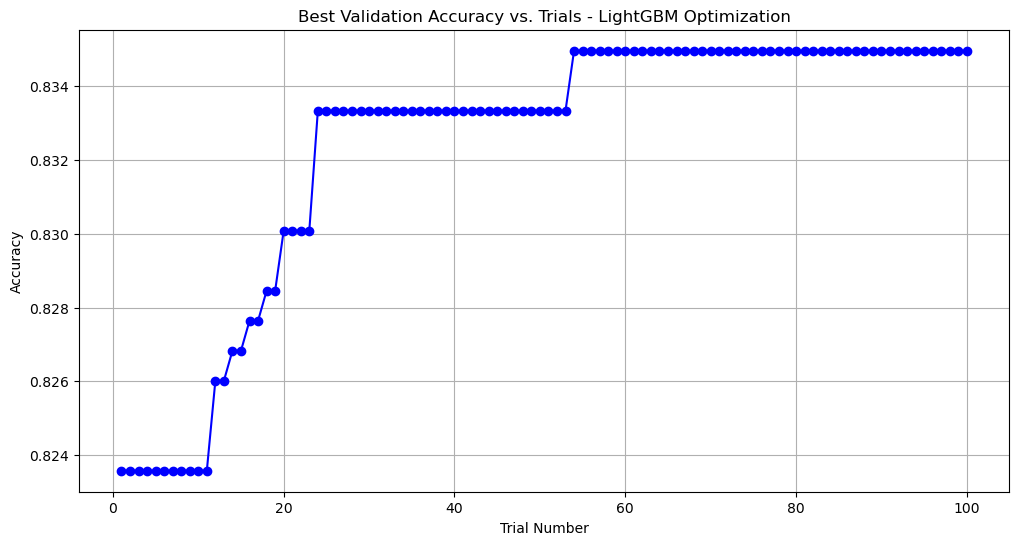

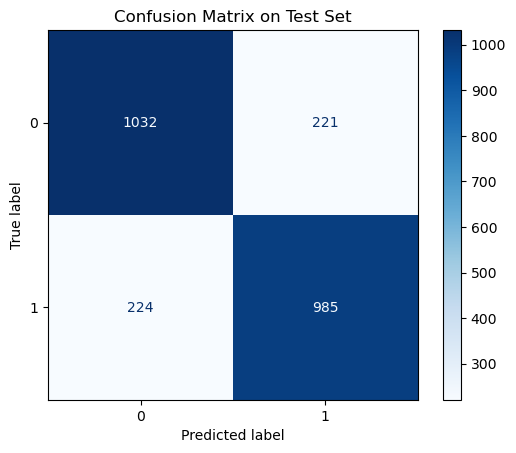

Best Hyperparameters: {'num_leaves': 76, 'learning_rate': 0.0795501835237614, 'feature_fraction': 0.9987049766595715, 'bagging_fraction': 0.9587119871180285, 'bagging_freq': 10, 'max_depth': 14, 'min_child_samples': 71, 'lambda_l1': 4.783960873716152, 'lambda_l2': 0.23226897771358931}
Best Model Accuracy on Test Set: 0.8192526401299757
Best Model F1-score on Test Set: 0.8157349896480331
Best Model Accuracy on Validation Set: 0.8349593495934959


In [50]:
# best hyperparameters
best_params = study.best_params

# train the logistic regression model with the best hyperparameters on the entire training set
best_lgb_model = lgb.LGBMClassifier(**best_params, verbose=-1, silence=True)
best_lgb_model.fit(X_train_scaled, y_train)

# track the best accuracy as the trials go on
best_accuracies = []
maximum_accuracy = 0
for trial in study.trials:
    model = lgb.LGBMClassifier(**trial.params, verbose=-1, silence=True)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    maximum_accuracy = max(maximum_accuracy, accuracy)
    best_accuracies.append(maximum_accuracy)

# plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(study.trials) + 1), best_accuracies, marker='o', linestyle='-', color='b')
plt.title('Best Validation Accuracy vs. Trials - LightGBM Optimization')
plt.xlabel('Trial Number')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# results on the test set
y_pred_test = best_lgb_model.predict(X_test_scaled)
y_pred_val = best_lgb_model.predict(X_val_scaled)
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_test_val = accuracy_score(y_val, y_pred_val)
f1_test = f1_score(y_test, y_pred_test, average='binary')
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=range(2))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

print(f"Best Hyperparameters: {best_params}")
print(f"Best Model Accuracy on Test Set: {accuracy_test}")
print(f"Best Model F1-score on Test Set: {f1_test}")
print(f"Best Model Accuracy on Validation Set: {accuracy_test_val}")

### Autoencoders
Autoencoders were attempted to be trained upon the actual images of scans from the dataset. This was considered as an approach due to its possible coverage and uncovering of previously unknown patterns that were unable to be captured quantitatively in our existing models. However, autoencoders proved to be difficult given the data format and the complex nature of the scans themselves and peaks. Initial MSE was able to be improved from approximately 0.01 to 0.0001 MSE per scan, but these results lacked interpretability and likely makes the existing above methods superior in comprehensive predictive power.

## Conclusions and Next Steps

Complex, but computationally efficient models like LightGBM classification appear to perform well relative to baseline, simple models like logistic regression. However, models like LightGBM appear to overfit to the train data and don't fully capture complex, underlying patterns to generalize optimally. Improvements to this can be made through the creation of new variables to better capture the nature of peaks, the location of peaks, and relationships between these peaks for each scan. Additionally, further deep learning techniques can be applied beyond these machine learning models to attempt to capture this complexity, as well. 

Additionally, although the performance of these models on the given dataset appear to be fairly robust, testing whether these models with the given attributes can generalize well to different samples could be useful. Specifically, testing whether larger training datasets enable models to generalize to samples not used in the training dataset (scans from different samples or different bio/tech reps) is important to understand how well this performs without being given information on the samples a priori. 